In [1]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from typing import Dict, List, Tuple, Any
import logging
from collections import defaultdict
from torchmetrics.detection import MeanAveragePrecision

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Cấu hình logger để hiển thị trên notebook
logging.basicConfig(
    level=logging.INFO,  
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

In [15]:
import pandas as pd
class LeafEDA:
    
    def __init__(self, img_dir: str, ann_file: str):
        self.img_dir = img_dir
        self.ann_file = ann_file
        self.coco = COCO(ann_file)
        self.img_ids = list(self.coco.imgs.keys())
        
        self.load_data()
        
    def load_data(self):
        """Load and organize all data"""
        print(" Loading data...")
        
        self.images_info = []
        self.annotations_info = []
        
        for img_id in self.img_ids:
            img_info = self.coco.loadImgs([img_id])[0]
            self.images_info.append({
                'image_id': img_id,
                'filename': img_info['file_name'],
                'width': img_info['width'],
                'height': img_info['height'],
                'area': img_info['width'] * img_info['height']
            })
            
            ann_ids = self.coco.getAnnIds(imgIds=[img_id])
            anns = self.coco.loadAnns(ann_ids)
            
            for ann in anns:
                self.annotations_info.append({
                    'ann_id': ann['id'],
                    'image_id': img_id,
                    'category_id': ann['category_id'],
                    'bbox': ann['bbox'],
                    'area': ann['area'],
                    'iscrowd': ann.get('iscrowd', 0),
                    'segmentation': ann['segmentation']
                })
        
        self.df_images = pd.DataFrame(self.images_info)
        self.df_annotations = pd.DataFrame(self.annotations_info)
        
        print(f"✅ Loaded {len(self.df_images)} images and {len(self.df_annotations)} annotations")
    
    def basic_statistics(self):
        print("\n BASIC STATISTICS")
        print("=" * 50)
        
        print("🖼️  IMAGE STATISTICS:")
        print(f"Total images: {len(self.df_images)}")
        print(f"Image sizes (W×H):")
        print(self.df_images[['width', 'height']].describe())
        
        print(f"\n🍃 ANNOTATION STATISTICS:")
        print(f"Total leaves: {len(self.df_annotations)}")
        leaves_per_image = self.df_annotations.groupby('image_id').size()
        print(f"Leaves per image: {leaves_per_image.mean():.2f}")
        
        return {
            'total_images': len(self.df_images),
            'total_leaves': len(self.df_annotations),
            'avg_leaves_per_image': leaves_per_image.mean()
        }
    
    def visualize_image_distribution(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].hist(self.df_images['width'], bins=30, alpha=0.7, label='Width')
        axes[0, 0].hist(self.df_images['height'], bins=30, alpha=0.7, label='Height')
        axes[0, 0].set_xlabel('Pixels')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Image Dimensions Distribution')
        axes[0, 0].legend()
        
        aspect_ratios = self.df_images['width'] / self.df_images['height']
        axes[0, 1].hist(aspect_ratios, bins=30, alpha=0.7, color='green')
        axes[0, 1].set_xlabel('Aspect Ratio (W/H)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Aspect Ratio Distribution')
        
        axes[1, 0].scatter(self.df_images['width'], self.df_images['height'], alpha=0.6)
        axes[1, 0].set_xlabel('Width')
        axes[1, 0].set_ylabel('Height')
        axes[1, 0].set_title('Width vs Height')
        
        leaves_per_image = self.df_annotations.groupby('image_id').size()
        axes[1, 1].hist(leaves_per_image, bins=20, alpha=0.7, color='orange')
        axes[1, 1].set_xlabel('Number of Leaves')
        axes[1, 1].set_ylabel('Number of Images')
        axes[1, 1].set_title('Leaves per Image Distribution')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_leaf_sizes(self):
        bbox_data = pd.DataFrame(self.df_annotations['bbox'].tolist(), 
                                 columns=['x', 'y', 'width', 'height'])
        bbox_data['area'] = bbox_data['width'] * bbox_data['height']
        bbox_data['aspect_ratio'] = bbox_data['width'] / bbox_data['height']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].hist(bbox_data['area'], bins=50, alpha=0.7, color='blue')
        axes[0, 0].set_xlabel('Leaf Area (pixels²)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Leaf Size Distribution')
        axes[0, 0].set_yscale('log')
        
        axes[0, 1].scatter(bbox_data['width'], bbox_data['height'], alpha=0.5)
        axes[0, 1].set_xlabel('Width')
        axes[0, 1].set_ylabel('Height')
        axes[0, 1].set_title('Leaf Width vs Height')
        
        axes[1, 0].hist(bbox_data['aspect_ratio'], bins=30, alpha=0.7, color='green')
        axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Leaf Aspect Ratio Distribution')
        
        axes[1, 1].axis('off')  # bỏ ô trống từng dùng cho boxplot theo plant_id
        
        plt.tight_layout()
        plt.show()
        
        return bbox_data

2025-06-02 04:29:10,200 [INFO] NumExpr defaulting to 4 threads.


In [16]:
eda = LeafEDA(img_dir="/kaggle/input/dataml/dataset/train/images", ann_file="/kaggle/input/dataml/dataset/train/annotations.json")

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
 Loading data...
✅ Loaded 432 images and 7136 annotations


In [17]:
stats = eda.basic_statistics()
print(stats)


 BASIC STATISTICS
🖼️  IMAGE STATISTICS:
Total images: 432
Image sizes (W×H):
             width       height
count   432.000000   432.000000
mean   1998.532407  2483.361111
std     210.030169   207.447462
min    1920.000000  1920.000000
25%    1920.000000  2560.000000
50%    1920.000000  2560.000000
75%    1920.000000  2560.000000
max    2568.000000  2566.000000

🍃 ANNOTATION STATISTICS:
Total leaves: 7136
Leaves per image: 16.52
{'total_images': 432, 'total_leaves': 7136, 'avg_leaves_per_image': 16.51851851851852}


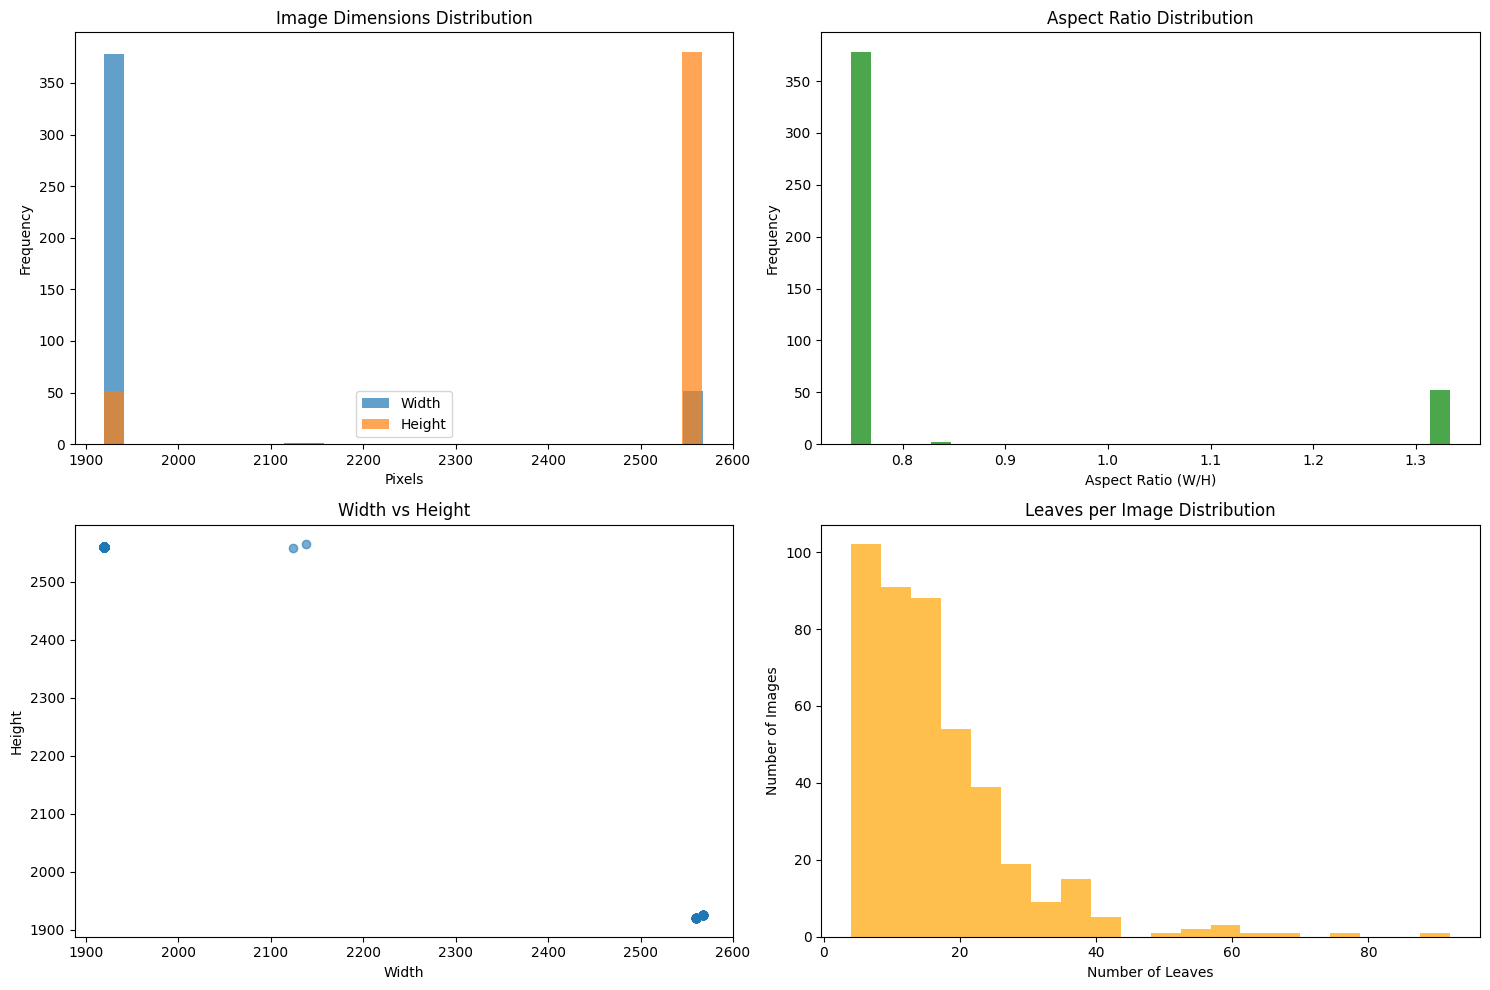

In [18]:
eda.visualize_image_distribution()

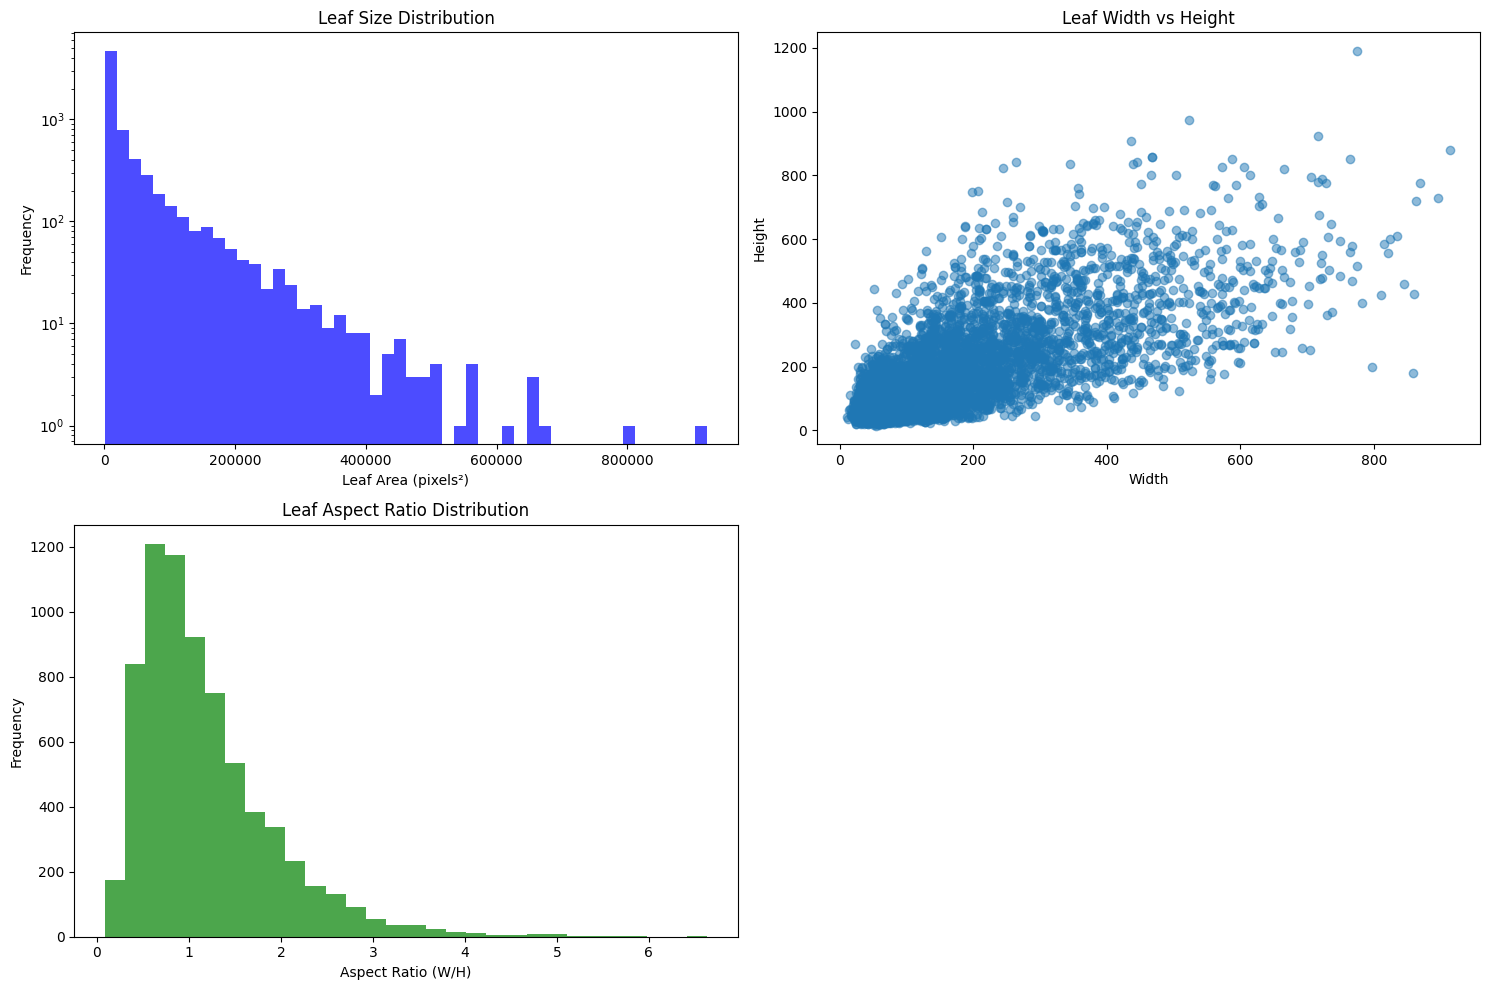

In [19]:
bbox_data = eda.analyze_leaf_sizes()


In [3]:
class LeafDataset(Dataset):
    
    def __init__(self, img_dir: str, ann_file: str, mode='train'):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.img_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
        self.mode = mode
        
        # Get category info
        self.categories = {cat['id']: cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())}
        logger.info(f"Dataset initialized with {len(self.img_ids)} images")
    
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]
        
        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)
        
        # Process annotations
        masks = []
        bboxes = []
        areas = []
        
        for ann in anns:
            # Get mask
            if isinstance(ann['segmentation'], list):
                # Polygon format
                rle = coco_mask.frPyObjects(ann['segmentation'], height, width)
                mask = coco_mask.decode(rle)
                if len(mask.shape) == 3:
                    mask = mask[:, :, 0]
            else:
                # RLE format
                mask = coco_mask.decode(ann['segmentation'])
            
            masks.append(mask)
            
            # Get bbox
            bbox = ann['bbox']  # [x, y, w, h]
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # [x1, y1, x2, y2]
            bboxes.append(bbox)
            
            # Get area
            areas.append(ann['area'])
        
        # Convert to tensors
        if len(masks) > 0:
            masks = np.stack(masks, axis=0)
            bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            labels = torch.ones((len(masks),), dtype=torch.int64)  # All are leaves
        else:
            # No annotations
            masks = torch.zeros((0, height, width), dtype=torch.uint8)
            bboxes = torch.zeros((0, 4), dtype=torch.float32)
            areas = torch.zeros((0,), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        
        target = {
            'boxes': bboxes,
            'labels': labels,
            'masks': masks,
            'areas': areas,
            'image_id': torch.tensor([img_id]),
            'iscrowd': torch.zeros((len(masks),), dtype=torch.int64)
        }
        
        
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            
        return image, target

In [4]:
class LeafMaskRCNN(nn.Module):
    """Standard Mask R-CNN for leaf instance segmentation (without plant_id)"""
    
    def __init__(self, num_classes=2, backbone_name='resnet50_v2'):
        super().__init__()
        
        from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
        from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
        from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
        
        # Load pre-trained model
        self.model = maskrcnn_resnet50_fpn_v2(pretrained=True)
        
        # Replace classifier
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        
        # Replace mask predictor
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        
    def forward(self, images, targets=None):
        return self.model(images, targets)

In [5]:
class LeafSegmentationTrainer:
    """Main trainer class with enhanced metrics"""
    
    def __init__(self, config: Dict):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")
        
        # Initialize datasets
        self.train_dataset = LeafDataset(
            img_dir=config['train_img_dir'],
            ann_file=config['train_ann_file'],
            mode='train'
        )
        
        self.val_dataset = LeafDataset(
            img_dir=config['val_img_dir'],
            ann_file=config['val_ann_file'],
            mode='val'
        )
        
        # Data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=config['num_workers'],
            collate_fn=self.collate_fn
        )
        
        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=2,
            shuffle=False,
            num_workers=config['num_workers'],
            collate_fn=self.collate_fn
        )
        
        # Initialize model
        self.model = LeafMaskRCNN(
            num_classes=config['num_classes']
        ).to(self.device)
        
        if config.get('optimizer', 'sgd') == 'adamw':
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(),
                lr=config['learning_rate'],
                weight_decay=0.01
            )
        else:
            self.optimizer = torch.optim.SGD(
                self.model.parameters(),
                lr=config['learning_rate'],
                momentum=0.9,
                weight_decay=0.0005
            )
        
        if config.get('scheduler', 'step') == 'cosine':
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer,
                T_max=config['num_epochs']
            )
        else:
            self.scheduler = torch.optim.lr_scheduler.StepLR(
                self.optimizer,
                step_size=config['step_size'],
                gamma=0.1
            )
        
        # Metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.val_maps = []
        self.val_ap50s = []
        
        # Initialize mAP metric
        self.map_metric = MeanAveragePrecision(
            box_format="xyxy",
            iou_type="segm",
            class_metrics=True
        )
        
    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))
    
    def train_epoch(self, epoch: int):
        """Train one epoch"""
        self.model.train()
        total_loss = 0.0
        num_batches = len(self.train_loader)
        
        for batch_idx, (images, targets) in enumerate(self.train_loader):
            # Move to device
            images = [img.to(self.device) for img in images]
            targets = [{k: v.to(self.device) if isinstance(v, torch.Tensor) else v 
                       for k, v in t.items()} for t in targets]
            
            # Forward pass
            self.optimizer.zero_grad()
            loss_dict = self.model(images, targets)
            
            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())
            
            # Backward pass
            losses.backward()
            self.optimizer.step()
            
            total_loss += losses.item()
            
            if batch_idx % 30 == 0:
                logger.info(f'Epoch {epoch}, Batch {batch_idx}/{num_batches}, '
                          f'Loss: {losses.item():.4f}')
                # Log individual losses
                for loss_name, loss_value in loss_dict.items():
                    logger.info(f'  {loss_name}: {loss_value.item():.4f}')
        
        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        logger.info(f'Epoch {epoch} Training Loss: {avg_loss:.4f}')
        
        return avg_loss
    
    def validate(self, epoch: int):
        """Validate model with mAP metrics"""
        self.model.eval()
        total_loss = 0.0
        num_batches = len(self.val_loader)
        
        # Reset metrics
        self.map_metric.reset()
        
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(self.val_loader):
                # Move to device
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) if isinstance(v, torch.Tensor) else v 
                           for k, v in t.items()} for t in targets]
                
                # Get predictions
                outputs = self.model(images)
                
                # Get losses (need to be in train mode)
                self.model.train()
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                self.model.eval()
                
                total_loss += losses.item()
                
                # Prepare predictions and targets for mAP calculation
                preds = []
                targs = []
                
                for i, (output, target) in enumerate(zip(outputs, targets)):
                    # Filter predictions by confidence threshold
                    keep = output['scores'] > 0.5
                    if keep.sum() > 0:
                        pred = {
                            'boxes': output['boxes'][keep],
                            'scores': output['scores'][keep],
                            'labels': output['labels'][keep],
                            'masks': output['masks'][keep].squeeze(1) > 0.5
                        }
                    else:
                        pred = {
                            'boxes': torch.empty((0, 4), device=self.device),
                            'scores': torch.empty(0, device=self.device),
                            'labels': torch.empty(0, dtype=torch.long, device=self.device),
                            'masks': torch.empty((0, *output['masks'].shape[-2:]), dtype=torch.bool, device=self.device)
                        }
                    
                    targ = {
                        'boxes': target['boxes'],
                        'labels': target['labels'],
                        'masks': target['masks'] > 0.5
                    }
                    
                    preds.append(pred)
                    targs.append(targ)
                
                # Update mAP metric
                self.map_metric.update(preds, targs)
        
        # Compute metrics
        metric_results = self.map_metric.compute()
        
        avg_loss = total_loss / num_batches
        map_score = metric_results['map'].item()
        map_50 = metric_results['map_50'].item()
        
        self.val_losses.append(avg_loss)
        self.val_maps.append(map_score)
        self.val_ap50s.append(map_50)
        
        # Log metrics
        logger.info(f'Epoch {epoch} Validation Results:')
        logger.info(f'  Loss: {avg_loss:.4f}')
        logger.info(f'  mAP: {map_score:.4f}')
        logger.info(f'  mAP@0.5: {map_50:.4f}')
        
        if 'map_75' in metric_results:
            logger.info(f'  mAP@0.75: {metric_results["map_75"].item():.4f}')
        
        return avg_loss, map_score
    
    def train(self):
        """Main training loop"""
        best_val_loss = float('inf')
        best_map = 0.0
        
        for epoch in range(self.config['num_epochs']):
            logger.info(f'Starting epoch {epoch + 1}/{self.config["num_epochs"]}')
            
            # Train
            train_loss = self.train_epoch(epoch)
            
            # Validate
            val_loss, val_map = self.validate(epoch)
            
            # Step scheduler
            self.scheduler.step()
            
            # Save best model based on mAP
            if val_map > best_map:
                best_map = val_map
                self.save_model(f'best_model_map_{epoch}.pth')
                logger.info(f'New best model saved with mAP: {val_map:.4f}')
            
            # Save best model based on loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_model(f'best_model_loss_{epoch}.pth')
            
            # Save checkpoint
            if (epoch + 1) % self.config['save_every'] == 0:
                self.save_model(f'checkpoint_epoch_{epoch}.pth')
        
        logger.info('Training completed!')
        logger.info(f'Best validation mAP: {best_map:.4f}')
        logger.info(f'Best validation loss: {best_val_loss:.4f}')
    
    def save_model(self, filename: str):
        """Save model checkpoint"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_maps': self.val_maps,
            'val_ap50s': self.val_ap50s,
            'config': self.config
        }
        
        os.makedirs(self.config['save_dir'], exist_ok=True)
        torch.save(checkpoint, os.path.join(self.config['save_dir'], filename))
        logger.info(f'Model saved: {filename}')
    
    def plot_metrics(self):
        """Plot training metrics"""
        try:
            import matplotlib.pyplot as plt
            
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            
            # Loss plot
            axes[0, 0].plot(self.train_losses, label='Train Loss')
            axes[0, 0].plot(self.val_losses, label='Val Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].set_title('Training and Validation Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(True)
            
            # mAP plot
            axes[0, 1].plot(self.val_maps, label='mAP', color='green')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('mAP')
            axes[0, 1].set_title('Validation mAP')
            axes[0, 1].legend()
            axes[0, 1].grid(True)
            
            # AP@0.5 plot
            axes[1, 0].plot(self.val_ap50s, label='mAP@0.5', color='blue')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('mAP@0.5')
            axes[1, 0].set_title('Validation mAP@0.5')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
            
            # Combined metrics
            axes[1, 1].plot(self.val_maps, label='mAP', color='green')
            axes[1, 1].plot(self.val_ap50s, label='mAP@0.5', color='blue')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].set_title('Combined Metrics')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
            
            plt.tight_layout()
            plt.savefig(os.path.join(self.config['save_dir'], 'training_metrics.png'), dpi=300)
            plt.show()
            
        except ImportError:
            logger.warning("Matplotlib not available, skipping plot generation")
    
    def get_metrics_summary(self):
        """Get summary of training metrics"""
        return {
            'final_train_loss': self.train_losses[-1] if self.train_losses else 0,
            'final_val_loss': self.val_losses[-1] if self.val_losses else 0,
            'best_map': max(self.val_maps) if self.val_maps else 0,
            'best_ap50': max(self.val_ap50s) if self.val_ap50s else 0,
            'final_map': self.val_maps[-1] if self.val_maps else 0,
            'final_ap50': self.val_ap50s[-1] if self.val_ap50s else 0,
        }

In [6]:
config = {
    # Data paths
    'train_img_dir': '/kaggle/input/dataml/dataset/train/images',
    'train_ann_file': '/kaggle/input/dataml/dataset/train/annotations.json',
    'val_img_dir': '/kaggle/input/dataml/dataset/val/images',
    'val_ann_file': '/kaggle/input/dataml/dataset/val/annotations.json',
    
    # Model parameters
    'num_classes': 2,  
    'backbone': 'resnet50_v2',
    
    'batch_size': 4,
    'num_epochs': 20,  
    'learning_rate': 0.001,  
    'optimizer': 'adamw', 
    'scheduler': 'cosine',  
    'step_size': 30,  
    'num_workers': 4,
    
    'save_dir': 'models',
    'save_every': 5,
}

2025-06-02 02:55:19,276 [INFO] Using device: cuda


loading annotations into memory...


2025-06-02 02:55:19,487 [INFO] Dataset initialized with 432 images
2025-06-02 02:55:19,551 [INFO] Dataset initialized with 108 images


Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 238MB/s] 
2025-06-02 02:55:22,025 [INFO] Starting epoch 1/20
2025-06-02 02:55:28,684 [INFO] Epoch 0, Batch 0/108, Loss: 3.5340
2025-06-

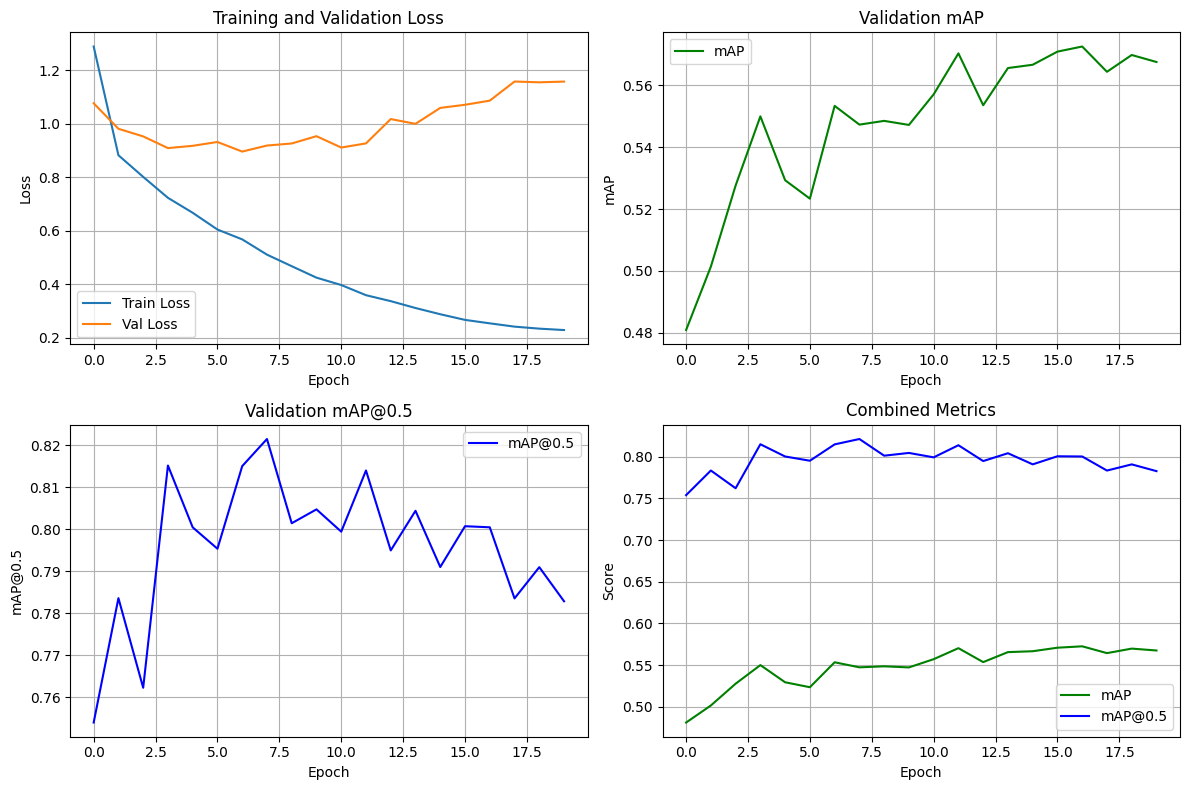

{'final_train_loss': 0.22896289632276254, 'final_val_loss': 1.1572101320381518, 'best_map': 0.5724637508392334, 'best_ap50': 0.8214261531829834, 'final_map': 0.5674673914909363, 'final_ap50': 0.7828516364097595}


In [7]:
trainer = LeafSegmentationTrainer(config)
    
    # Start training
trainer.train()
trainer.plot_metrics()
print(trainer.get_metrics_summary())

In [8]:
from skimage import measure

class LeafInference:
    
    def __init__(self, model_path: str, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=self.device)
        config = checkpoint['config']
        
        # Initialize model
        self.model = LeafMaskRCNN(
            num_classes=config['num_classes']
        ).to(self.device)
        
        # Load weights
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        logger.info('Model loaded successfully')
    
    def predict(self, image_path: str, confidence_threshold: float = 0.5):
        """Predict on single image"""
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Preprocess
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        image_tensor = image_tensor.unsqueeze(0).to(self.device)
        
        # Predict
        with torch.no_grad():
            predictions = self.model(image_tensor)[0]
        
        # Filter by confidence
        keep = predictions['scores'] > confidence_threshold
        
        results = {
            'boxes': predictions['boxes'][keep].cpu().numpy(),
            'scores': predictions['scores'][keep].cpu().numpy(),
            'masks': predictions['masks'][keep].cpu().numpy(),
            'labels': predictions['labels'][keep].cpu().numpy(),
        }
        
        return results, image
    
    def visualize_results(self, image, results, save_path: str = None):
        """Visualize prediction results using polygon masks only (no box, no label)"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image)
    
        for i in range(len(results['masks'])):
            mask = results['masks'][i, 0] > 0.5
    
            # Tìm contour từ mask nhị phân
            contours = measure.find_contours(mask, level=0.5)
    
            for contour in contours:
                # scale contour theo chiều (y, x) -> (x, y)
                polygon = np.flip(contour, axis=1)
                ax.plot(polygon[:, 0], polygon[:, 1], linewidth=0.5, color='lime')
    
        ax.set_title(f'Detected {len(results["masks"])} leaf instances')
        ax.axis('off')
    
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

2025-06-02 04:13:31,389 [INFO] Model loaded successfully


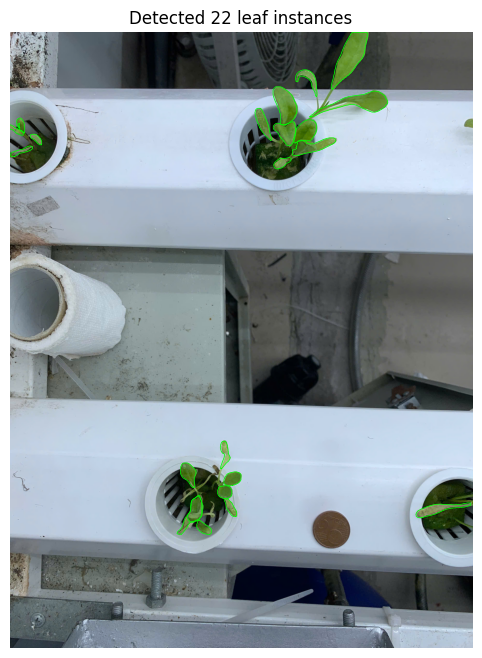

In [10]:
inference = LeafInference(model_path='/kaggle/working/models/checkpoint_epoch_19.pth')
results, image = inference.predict('/kaggle/input/dataml/dataset/val/images/2.x11.1.7.259.20022025.jpg', confidence_threshold=0.5)
inference.visualize_results(image, results)

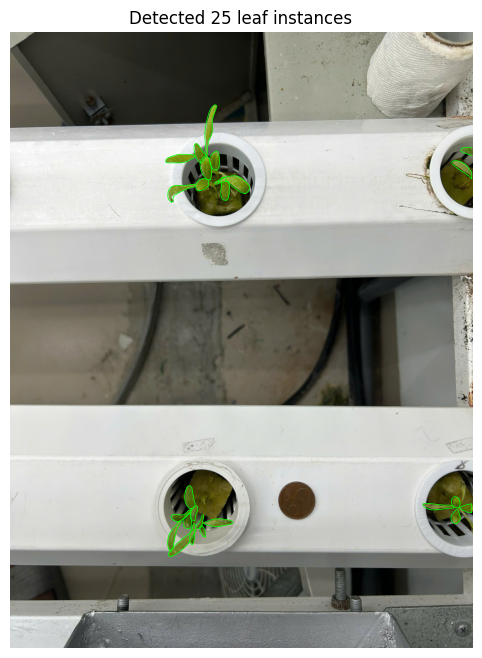

In [11]:
results, image = inference.predict('/kaggle/input/dataml/dataset/val/images/2.x11.2.7.266.16022025(3).jpg', confidence_threshold=0.5)
inference.visualize_results(image, results)

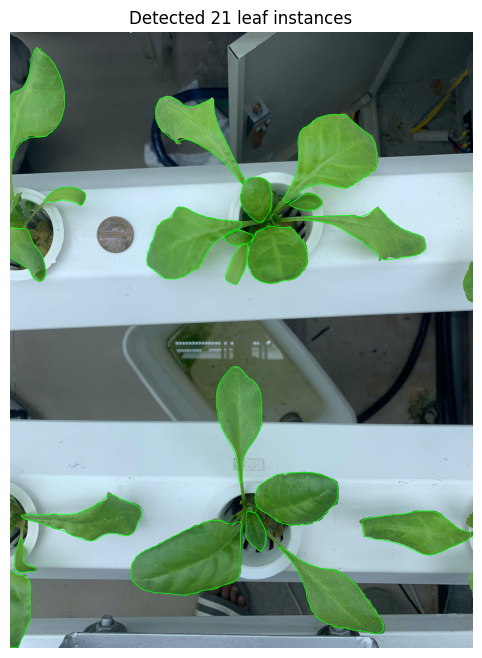

In [12]:
results, image = inference.predict('/kaggle/input/dataml/dataset/val/images/2.x2.3.6.41.07012025.jpg', confidence_threshold=0.5)
inference.visualize_results(image, results)